## Denoising Autoencoder for MNIST

Examples of simple autoencoders (DNN,CNN) built for the task of learning a useful latent representation of an input image from MNIST, such that it is able to denoise input images. The CNN autoencoder does a better job than the simpler DNN autoencoder, but neither of the models does a remarkable job, due to their relative simplicity.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
y_train # labels are pre-shuffled for testing and training

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### Data Preparation

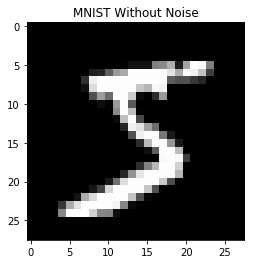

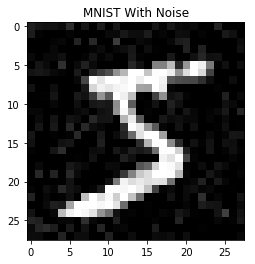

In [5]:
example = x_train[0]

noise = np.random.randn(28,28)*20
example_with_noise = np.minimum(255,np.maximum(0,example+noise)) # ensuring valid pixel values

plt.imshow(example,cmap="gray")
plt.title("MNIST Without Noise")
plt.show()

plt.imshow(example_with_noise,cmap="gray")
plt.title("MNIST With Noise")
plt.show()

In [6]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [7]:
# adding noise to the MNIST data
noise_train = np.random.randn(x_train.shape[0],28,28)*20
noise_test = np.random.randn(x_test.shape[0],28,28)*20

In [8]:
x_train_w_noise = np.minimum(255,np.maximum(0,x_train+noise_train))
x_test_w_noise = np.minimum(255,np.maximum(0,x_test+noise_test))

### Simple DNN Autoencoder

In [9]:
class SimpleNet(nn.Module):
    """ 784x1 -> 300x1 -> 100x1(h) -> 300x1 -> 784x1
    """
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(784,300)
        self.h2 = nn.Linear(300,100) # encoding to 100x1
        self.h3 = nn.Linear(100,300) # upsampling
        self.h4 = nn.Linear(300,784)
    
    def forward(self, x):
        x = x.view(x.shape[0],784) # 784x1
        x = F.relu(self.h1(x)) # 300x1
        x = F.relu(self.h2(x)) # 100x1
        x = F.relu(self.h3(x)) # 300x1
        x = self.h4(x) # 784x1
        return x

In [10]:
net = SimpleNet()

In [11]:
X = torch.from_numpy(x_train_w_noise)
y = torch.from_numpy(x_train.reshape(x_train.shape[0],784))
X = X.float()
y = y.float()
X.shape,y.shape,X.dtype,y.dtype

(torch.Size([60000, 28, 28]),
 torch.Size([60000, 784]),
 torch.float32,
 torch.float32)

In [12]:
optimizer = optim.Adam(net.parameters(),lr=0.005)
loss_criterion = nn.MSELoss()
epochs = 30
batch_size=500

In [13]:
# training iteration
for i in range(epochs):
    batch_losses = []
    for j in range(0,X.shape[0],batch_size):
        temp_X = X[j:j+500,:,:]
        temp_y = y[j:j+500,:]
        optimizer.zero_grad()
        output = net(temp_X)
        loss = loss_criterion(output,temp_y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss)
    print("Epoch {} loss: {}".format(i+1,sum(batch_losses)/len(batch_losses)))

Epoch 1 loss: 3786.951416015625
Epoch 2 loss: 2265.785888671875
Epoch 3 loss: 1820.6031494140625
Epoch 4 loss: 1606.532958984375
Epoch 5 loss: 1487.5386962890625
Epoch 6 loss: 1404.87841796875
Epoch 7 loss: 1346.47705078125
Epoch 8 loss: 1303.0750732421875
Epoch 9 loss: 1267.8399658203125
Epoch 10 loss: 1235.2454833984375
Epoch 11 loss: 1205.9935302734375
Epoch 12 loss: 1178.104736328125
Epoch 13 loss: 1154.2095947265625
Epoch 14 loss: 1125.204345703125
Epoch 15 loss: 1105.3653564453125
Epoch 16 loss: 1091.1900634765625
Epoch 17 loss: 1077.771240234375
Epoch 18 loss: 1066.2027587890625
Epoch 19 loss: 1057.53857421875
Epoch 20 loss: 1050.50341796875
Epoch 21 loss: 1043.0640869140625
Epoch 22 loss: 1039.8909912109375
Epoch 23 loss: 1027.786376953125
Epoch 24 loss: 1026.19482421875
Epoch 25 loss: 1018.8661499023438
Epoch 26 loss: 1016.8375854492188
Epoch 27 loss: 1010.8849487304688
Epoch 28 loss: 1007.7642822265625
Epoch 29 loss: 1004.0248413085938
Epoch 30 loss: 1002.7434692382812


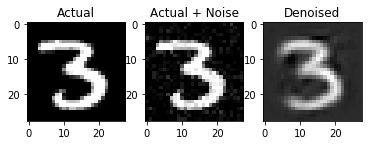

In [14]:
# training set example, using the simple denoising autoencoder
img_i = 12
example = x_train[img_i]
example_w_noise = x_train_w_noise[img_i]
with torch.no_grad():
    torch_example = torch.from_numpy(example_w_noise)
    torch_example = torch_example.float()
    torch_example = torch_example.unsqueeze(0)
    out = net.forward(torch_example) # denoised from the model
    out = out.numpy()
    out.shape = (28,28)

plt.subplot(1,3,1)
plt.title("Actual")
plt.imshow(example,cmap="gray")
plt.subplot(1,3,2)
plt.title("Actual + Noise")
plt.imshow(example_w_noise,cmap="gray")
plt.subplot(1,3,3)
plt.title("Denoised")
plt.imshow(out,cmap="gray")
plt.show()

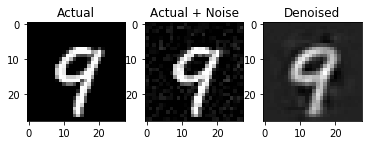

In [15]:
# testing set example, using the simple denoising autoencoder
img_i = 12
example = x_test[img_i]
example_w_noise = x_test_w_noise[img_i]
with torch.no_grad():
    torch_example = torch.from_numpy(example_w_noise)
    torch_example = torch_example.float()
    torch_example = torch_example.unsqueeze(0)
    out = net.forward(torch_example) # denoised from the model
    out = out.numpy()
    out.shape = (28,28)

plt.subplot(1,3,1)
plt.title("Actual")
plt.imshow(example,cmap="gray")
plt.subplot(1,3,2)
plt.title("Actual + Noise")
plt.imshow(example_w_noise,cmap="gray")
plt.subplot(1,3,3)
plt.title("Denoised")
plt.imshow(out,cmap="gray")
plt.show()

### Simple CNN Autoencoder

In [16]:
class CnnNet(nn.Module):
    """ input shape: (batch_size,num_channels,length,width)
    """
    def __init__(self):
        super().__init__()
        self.up = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv1 = nn.Conv2d(1,8,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(8,8,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(8,8,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(8,1,kernel_size=3,padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) # (1,1,28,28)
        x = F.max_pool2d(x,(2,2)) # (1,8,14,14)
        x = F.relu(self.conv2(x)) # (1,8,14,14)
        x = F.max_pool2d(x,(2,2)) # (1,8,7,7) latent representation
        x = self.up(x) # (1,8,14,14)
        x = F.relu(self.conv3(x)) # (1,8,14,14)
        x = self.up(x) # (1,8,28,28)
        x = self.conv4(x) # (1,1,28,28)
        x = x.view(x.shape[0],784) # (1,784)
        return x

In [17]:
net2 = CnnNet()

In [18]:
optimizer = optim.Adam(net2.parameters(),lr=0.003)
loss_criterion = nn.MSELoss()
epochs = 9
batch_size=500

In [19]:
# training iteration
for i in range(epochs):
    batch_losses = []
    for j in range(0,X.shape[0],batch_size):
        temp_X = X[j:j+500,:,:]
        temp_y = y[j:j+500,:]
        temp_X = temp_X.unsqueeze(1)
        optimizer.zero_grad()
        output = net2(temp_X)
        loss = loss_criterion(output,temp_y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss)
    print("Epoch {} loss: {}".format(i+1,sum(batch_losses)/len(batch_losses)))

Epoch 1 loss: 2558.537841796875
Epoch 2 loss: 1118.1544189453125
Epoch 3 loss: 916.61328125
Epoch 4 loss: 830.9508666992188
Epoch 5 loss: 782.1448974609375
Epoch 6 loss: 749.9124145507812
Epoch 7 loss: 721.8406982421875
Epoch 8 loss: 697.7317504882812
Epoch 9 loss: 676.265625


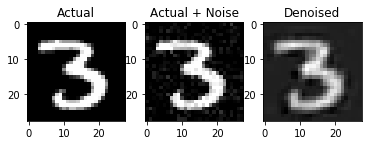

In [20]:
# training set example, using the cnn denoising autoencoder (same example as with the simpler autoencoder)
img_i = 12
example = x_train[img_i]
example_w_noise = x_train_w_noise[img_i]
with torch.no_grad():
    torch_example = torch.from_numpy(example_w_noise)
    torch_example = torch_example.float()
    torch_example = torch_example.unsqueeze(0)
    torch_example = torch_example.unsqueeze(0)
    out = net2.forward(torch_example) # denoised from the model
    out = out.numpy()
    out.shape = (28,28)

plt.subplot(1,3,1)
plt.title("Actual")
plt.imshow(example,cmap="gray")
plt.subplot(1,3,2)
plt.title("Actual + Noise")
plt.imshow(example_w_noise,cmap="gray")
plt.subplot(1,3,3)
plt.title("Denoised")
plt.imshow(out,cmap="gray")
plt.show()

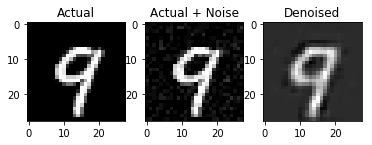

In [21]:
# testing set example, using the cnn denoising autoencoder (same example as with the simpler autoencoder)
img_i = 12
example = x_test[img_i]
example_w_noise = x_test_w_noise[img_i]
with torch.no_grad():
    torch_example = torch.from_numpy(example_w_noise)
    torch_example = torch_example.float()
    torch_example = torch_example.unsqueeze(0)
    torch_example = torch_example.unsqueeze(0)
    out = net2.forward(torch_example) # denoised from the model
    out = out.numpy()
    out.shape = (28,28)

plt.subplot(1,3,1)
plt.title("Actual")
plt.imshow(example,cmap="gray")
plt.subplot(1,3,2)
plt.title("Actual + Noise")
plt.imshow(example_w_noise,cmap="gray")
plt.subplot(1,3,3)
plt.title("Denoised")
plt.imshow(out,cmap="gray")
plt.show()